<a href="https://colab.research.google.com/github/gt-cse-6040/bootcamp/blob/main/Module%200/Session%2011/working_MT1%20Hard%20Debugging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debugging Bad Solutions: #
## From Midterm 1, Spring 2023 - 2 and 3 Point Exercises ##

**Purpose:**
On the exams you may initially write solutions that do not pass the test cases. That's okay! You will need to debug your code to determine what is causing the issue(s) and then figure out to how fix them. So how can we get better at debugging? We practice!

Below are four 1 point exercises from the Spring 2023 Midterm 1. We have pre-written solutions for each exercise that are "bad" in one or more ways. Our solutions may contain one or more logic and/or syntax errors. Can you find and fix the issues in each exercise and pass all of the test cases?

Right before each exercise test cell, there is a block of text explaining the variables available to you for debugging. You may use these to test your code and can print/display them as needed.

<br/>

**Exercise point breakdown:**

- Exercise 2: **3** points
- Exercise 8: **2** points
- Exercise 9: **3** points


# Background: Mining for Friends #

In this notebook, you will analyze social media data from Twitter and FourSquare. Your ultimate goal will be to help people find others with common interests.

The (anonymized) data consists of the following:

- A collection of places, or _points of interest_ (POIs), like restaurants, movie theaters, post offices, museums, and so on.
- A database of cities.
- A collection of _check-ins_, that is, the places that a specific person has visited.
- Existing _connections_, that is, "who follows whom" type relationships.

We will analyze this data and then, by the very last exercise, create a function that can, for a given person, recommend other people they might be compatible with based on their affinity for the same places.

Start by running the next cell, which will set up some of the code and data you'll need later.

In [ ]:
# # !python --version
!pip install dill
import dill as pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
### Global Imports
# Some functionality needed by the notebook and demo cells:
from pprint import pprint, pformat
import math

def status_msg(s, time=None):
    from datetime import datetime
    if time is None:
        time = datetime.now()
    print(f"[{time}] {s}")

def load_json(filename):
    from json import load
    with open(filename, "rt") as fp:
        return load(fp)
    return None

def save_json(filename, obj):
    from json import dump
    with open(filename, "w") as fp:
        dump(obj, fp, indent=2)

def load_pickle(filename):
    from pickle import load
    with open(filename, "rb") as fp:
        return load(fp)
    return None

def save_pickle(filename, obj):
    from pickle import dump
    with open(filename, "wb") as fp:
        dump(obj, fp)

def choose_ext(s, ext_map):
    for ext in ext_map:
        if s[-(len(ext)+1):] == f".{ext}":
            return ext_map[ext]
    return None

def load_database(basename, tag=None, sample=None, pathname=""):
    filename = pathname + basename
    status_msg(f"Loading {tag+' ' if tag is not None else ''}[{filename}] ...")
    loader = choose_ext(basename, {'pickle': load_pickle, 'json': load_json})
    assert loader is not None, "*** Unrecognized file extension. ***"
    database = loader(filename)
    status_msg("... done!")
    print(f"\nThis data has {len(database):,} entries.")
    if sample is not None and isinstance(database, dict):
        print("\nHere is a sample:\n")
        pprint({key: database[key] for key in sample})
    return database

def save_database(database, basename, tag=None, sample=None, pathname=""):
    if sample is not None and isinstance(database, dict):
        database = {key: database[key] for key in sample}
    print(f"This data has {len(database):,} entries.")
    filename = pathname + basename
    status_msg(f"\nSaving {tag+' ' if tag is not None else ''}[{filename}] ...")
    saver = choose_ext(basename, {'pickle': save_pickle, 'json': save_json})
    assert saver is not None, "*** Unrecognized file extension. ***"
    saver(filename, database)
    status_msg("... done!")

def sample_dict(d, k=1):
    """Extract a sample of at most `k` key-value pairs from the dictionary `d`."""
    assert k >= 0, f"*** The number of samples must be nonnegative (k={k}). ***"
    from random import sample
    keys = sample(d.keys(), min(k, len(list(d.keys()))))
    return {k: d[k] for k in keys}

def sample_safely(x, k):
    """Returns a set of at most `k` uniform-random samples from `x`."""
    from random import sample
    return set(sample(x, min(k, len(x))))

def subset_dict(d, ks):
    """Returns a subset of the dictionary `d` for the keys `ks`."""
    return {k: v for k, v in d.items() if k in ks}

def enum_map(x):
    map_dict = {e: k for k, e in enumerate(x)}
    return lambda i: map_dict[i]

def remap_dict(d, map_key=lambda k: k, map_val=lambda k: k):
    """Relabel the key-value pairs of a dictionary."""
    assert len(set(map_key(k) for k in d.keys())) == len(d.keys()), '*** `map_key` is not one to one ***'
#    assert len(set(map_val(k) for k in d.values())) == len(d.values()), '*** `map_val` is not one to one ***'
    return {map_key(k): map_val(v) for k, v in d.items()}

def remap_set(s, map_fun=lambda e: e):
    """Relabel the elements of a set."""
    s_new = {map_fun(e) for e in s}
    assert len(s_new) == len(s), "*** `map_fun` is not one to one ***"
    return s_new

In [ ]:
# # import files
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/active_users.pickle
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/cc_visit_counts.pickle
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/checkins2.pickle
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/cities.pickle
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/connection_vectors.pickle
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/connections.pickle
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/filtered_pois.pickle
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/food_and_drink_types.pickle
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/pois2.pickle
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/sims.pickle
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/visit_vectors.pickle
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/tc_2
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/tc_8
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/tc_9

!mkdir tester_fw
%cd tester_fw

!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/tester_fw/__init__.py
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/tester_fw/test_utils.py
!wget https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/tester_fw/testers.py

%cd ..

--2023-12-11 21:50:43--  https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/active_users.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404627 (395K) [application/octet-stream]
Saving to: ‘active_users.pickle’

active_users.pickle 100%[===================>] 395.14K  --.-KB/s    in 0.05s   

2023-12-11 21:50:43 (8.06 MB/s) - ‘active_users.pickle’ saved [404627/404627]

--2023-12-11 21:50:43--  https://raw.githubusercontent.com/gt-cse-6040/bootcamp/main/Module%200/Session%2011/Colab%20Support%20Files/cc_visit_counts.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuse

# Part A: Points-of-interest and cities #

The first part of the dataset consists of **points-of-interest** or **POIs**. A POI is a place that a person can visit.

Run this code cell to load the dataset of POIs.

In [ ]:
pois = load_database('pois2.pickle',
                     tag="points-of-interest (POIs)")

[2023-12-11 19:41:43.565702] Loading points-of-interest (POIs) [pois2.pickle] ...
[2023-12-11 19:41:44.253283] ... done!

This data has 350,000 entries.


There are over half-a-million POIs. Each one is stored as a key-value pair where
- the key is the **POI's ID**; and
- the value holds the **POI's attributes**, stored as another Python dictionary.

In the sample above, there are three POIs, each one with four attributes.
- **`'country_code'`**: A two-letter country code indicating in which country the POI is located. In this example, one is in Brazil (`'BR'`) and two in Turkey (`'TR'`).
- **`'lat'` and `'long'`**: The latitude and longitude coordinates of the POI.
- **`'type'`**: The type of POI. We see three types in this example: a `'University'`, a `'Automotive Shop'`, and a `'Turkish Restaurant'`.

In [ ]:
food_and_drink_types = load_database('food_and_drink_types.pickle')
print(f"\nThere are {len(food_and_drink_types):,} types that match the food and drink keywords. They are:")
print(food_and_drink_types)

[2023-12-11 19:41:44.267036] Loading [food_and_drink_types.pickle] ...
[2023-12-11 19:41:44.268023] ... done!

This data has 81 entries.

There are 81 types that match the food and drink keywords. They are:
{'African Restaurant', 'Beer Garden', 'Dumpling Restaurant', 'South American Restaurant', 'Australian Restaurant', 'Coffee Shop', 'Vegetarian / Vegan Restaurant', 'American Restaurant', 'Molecular Gastronomy Restaurant', 'Fast Food Restaurant', 'Food Truck', 'Gay Bar', 'Mexican Restaurant', 'Peruvian Restaurant', 'Dive Bar', 'Caribbean Restaurant', 'Hotel Bar', 'Southern / Soul Food Restaurant', 'Swiss Restaurant', 'Greek Restaurant', 'Portuguese Restaurant', 'Falafel Restaurant', 'Tapas Restaurant', 'Internet Cafe', 'Scandinavian Restaurant', 'Indonesian Restaurant', 'Whisky Bar', 'Apres Ski Bar', 'Food & Drink Shop', 'Afghan Restaurant', 'Gaming Cafe', 'Japanese Restaurant', 'Thai Restaurant', 'Cafe', 'Argentinian Restaurant', 'Middle Eastern Restaurant', 'Latin American Restauran

# Part B: Cities #

A second component of the dataset is a collection of **city records**. Run the following cell to load it.

In [ ]:
cities = load_database('cities.pickle',
                       tag="cities",
                       sample = ["Beijing, China", "Hartford, United States", "Stockholm, Sweden"])

[2023-12-11 19:41:44.282393] Loading cities [cities.pickle] ...
[2023-12-11 19:41:44.284646] ... done!

This data has 415 entries.

Here is a sample:

{'Beijing, China': {'country_code': 'CN',
                    'lat': 39.906189,
                    'long': 116.388037,
                    'type': 'National and provincial capital'},
 'Hartford, United States': {'country_code': 'US',
                             'lat': 41.76,
                             'long': -72.702999,
                             'type': 'Provincial capital'},
 'Stockholm, Sweden': {'country_code': 'SE',
                       'lat': 59.331168,
                       'long': 17.991451,
                       'type': 'National and provincial capital'}}


Each city record is a key-value pair. The key is the **city name**, and the value is a dictionary of **city attributes**. The attributes are a two-letter country code, the latitude and longitude coordinates of the city center, and the type of city.

In this example, there are three cities: `'Beijing, China'`, `'Hartford, United States'`, and `'Stockholm, Sweden'`.

**Important!** Both the POIs and the cities are dictionaries of dictionaries, where in both cases the _outer_ dictionary's key-value pairs define a record, and the inner dictionaries have the keys, `'country_code'`, `'lat'`, `'long'`, and `'type'`.

## Exercise 2 (**3** points): `proximity_join` ##

POI records only have lat-long coordinates. To make their locations more user-friendly, let's associate each POI with its closest city in the same country.

Implement the function,
```python
def proxmity_join(pois, cities):
    ...
```
to help accomplish this task, following the requirements below.

**Inputs:**

- `pois`: POIs, stored in a Python dictionary of dictionaries, mapping POI IDs keys to attribute values (like Exercise 1)
- `cities`: City records, stored in a Python dictionary of dictionaries, mapping city names to attribute values (like Exercise 1)

You may assume that the inner dictionaries of both have the same four keys: `'country_code'`, `'lat'`, `'long'`, and `'type'`.

**Task:** For each POI record, determine which city is _closest_ to it. The closest city must be in the same country (the `'country_code'` values must match).

To measure distance, use the _squared Euclidean distance_. That is, if a POI record has the lat-long coordinates $(h_p, v_p)$, and a city record has the lat-long coordinates $(h_c, v_c)$, then their squared Euclidean distance is

$$(h_p - h_c)^2 + (v_p - v_c)^2.$$

**Outputs:** Your function should return a **new Python dictionary of dictionaries**. The outer dictionary's keys should be the same POI IDs. The inner dictionary should have exactly two keys: `'type'`, which is the **POI type** (not the _city type_), and `'city'`, which is the name of the closest city. See the demo below.

**Notes and hints:**
1. Recall that the IEEE floating-point standard defines a special value that corresponds with infinity. This value is available in Python as `math.inf`, and it may be a helpful initializer as you search for the closest city to a given POI.
2. We have provided a function, `dd_distance_squared`, that will compute the squared Euclidean distance given the attributes of a POI and the attributes of a city.

In [ ]:
### DEMO INPUTS ###
demo_pois_ex2 = \
    {'abc': {'country_code': 'US', 'lat': -5.2, 'long': 2.0, 'type': 'Restaurant'},
     'def': {'country_code': 'US', 'lat': -2.3, 'long': 6.8, 'type': 'Golf Course'},
     'ghi': {'country_code': 'PL', 'lat': 1.0, 'long': 6.5, 'type': 'Apartment'},
     'jkl': {'country_code': 'VN', 'lat': 11.0, 'long': 1.5, 'type': 'Post Office'}}

demo_cities_ex2 = \
    {'Seattle, United States': {'country_code': 'US', 'lat': -5.0, 'long': 3.0, 'type': 'Other'},
     'Richmond, United States': {'country_code': 'US', 'lat': -2.0, 'long': 7.0, 'type': 'Other'},
     'Hanoi, Vietnam': {'country_code': 'VN', 'lat': 10.0, 'long': 2.0, 'type': 'National and provincial capital'},
     'Curitiba, Brazil': {'country_code': 'BR', 'lat': 0.0, 'long': 6.0, 'type': 'Provincial capital'}}

<!-- Expected demo output text block -->
The demo included in the solution cell below should display the following output:
```
{'abc': {'type': 'Restaurant', 'city': 'Seattle, United States'},
 'def': {'type': 'Golf Course', 'city': 'Richmond, United States'},
 'jkl': {'type': 'Post Office', 'city': 'Hanoi, Vietnam'}}
 ```
<!-- Include any shout outs here -->

Observe that the POI `'ghi'` does **not** appear in the output. That's because its country code, `'PL'`, does not match any country code of any city.

In [ ]:
#from _typeshed import IdentityFunction
### Exercise 2 solution

def proximity_join(pois, cities):
    '''
    GOAL:
    -For each POI record, determine which city is closest to it.
    -Measure squared Euclidean distance using function 'dd_distance_squared' provided.
    -Return a new Python dictionary of dictionaries. The outer dictionary's keys should be the same POI IDs.
    The inner dictionary should have exactly two keys: 'type', which is the POI type (not the city type), and 'city', which is the name of the closest city.

    INPUT:
    2 inputs:
    pois: POIs, stored in a Python dictionary of dictionaries, mapping POI IDs keys to attribute values
    cities: City records, stored in a Python dictionary of dictionaries, mapping city names to attribute values

    STRATEGY:
    1. Create empty dictionary to hold POI: {type: '', city: ''}. Let's call this 'closest_city_dict'
    2. Initialize some sort of giant distance to compare our euclidean distances to (infinity based on the hint above).
    3. Iterate over each poi in 'pois'
    4. Grab type from its nested dictionary and store as a variable.
    5. Iterate over each city in 'cities'
    6. Calculate the squared Euclidean distance. Use handy function 'dd_distance_squared' provided below.
    7. If distance is less than euclidean distance thus far, update 'closest_city_dict' info for that poi.
    8. Return 'closest_city_dict'
    '''

    # SOLUTION:
    from math import inf
    closest_city_dict = {}

    euclid_dist = inf

    for poi in pois:
      poi_nested_dict = pois[poi]
      poi_type = poi_nested_dict['type']
      for city in cities:
        city_nested_dict = cities[city]
        calc_euclid_dist = dd_distance_squared(poi_nested_dict, city_nested_dict)
        if calc_euclid_dist < euclid_dist:
          closest_city_dict[poi] = {'type': poi_type, 'city': city}

    return closest_city_dict


# Handy function to calculate the distance between one POI and one city:
def dd_distance_squared(poi_attr, city_attr):
    p_lat, p_long = poi_attr['lat'], poi_attr['long']
    c_lat, c_long = city_attr['lat'], city_attr['long']
    return (p_lat - c_lat)**2 + (p_long - c_long)**2

### demo function call
proximity_join(demo_pois_ex2, demo_cities_ex2)

{'abc': {'type': 'Restaurant', 'city': 'Curitiba, Brazil'},
 'def': {'type': 'Golf Course', 'city': 'Curitiba, Brazil'},
 'ghi': {'type': 'Apartment', 'city': 'Curitiba, Brazil'},
 'jkl': {'type': 'Post Office', 'city': 'Curitiba, Brazil'}}

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 2. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution.
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output.

In [ ]:
### test_cell_ex2
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_2',
    'func': proximity_join, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'pois':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
        'cities':{
            'dtype':'dict',
            'check_modified':True,
        },
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'dict',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

print('Passed! Please submit.')

AssertionError: ignored

# Part C: Check-ins #

The next part of the dataset consists of **check-in records**. Run the cell below to load this data.

In [ ]:
checkins = load_database('checkins2.pickle',
                         tag="check-in records",
                         sample=[119_352, 677_020, 728_580])

[2023-12-11 19:42:03.759418] Loading check-in records [checkins2.pickle] ...
[2023-12-11 19:42:04.227397] ... done!

This data has 75,000 entries.

Here is a sample:

{119352: [{'date': 'Sat Apr 07 21:37:04 +0000 2012',
           'poi': '4b8e7128f964a520e02233e3'},
          {'date': 'Wed May 09 01:07:21 +0000 2012',
           'poi': '40e0b100f964a5206b061fe3'}],
 677020: [{'date': 'Sat Jul 14 05:42:40 +0000 2012',
           'poi': '4c4eb3bfc1f5ef3b4a1e46ab'},
          {'date': 'Sun Jun 17 16:57:38 +0000 2012',
           'poi': '4e465895483b03d090de4bd3'}],
 728580: [{'date': 'Sun May 13 02:17:54 +0000 2012',
           'poi': '4bbcfcde593fef3b0ce90256'}]}


Each _check-in record_ (or just _check-in_) is a key-value pair, where
- the key is a **user** ID, an _integer_; and
- the value is a _Python list_ of one or more **visits**.

Each **visit** is itself a Python dictionary with two key-value pairs:
- `'poi'`: The POI that the user visited, represented by its string ID.
- `'date'`: The date of that visit, stored as a string.

In the preceding example, there are three users, `119352`, `677020`, and `728580`. They each visited four, seven, and one POI, respectively. User `728580` visited the one POI on Sunday, May 13, 2012. A user can visit the same POI on different dates; for example, user `119352` made two visits to POI `4ab4edf1f964a520ad7120e3`, once on April 16 and again on April 23.

In [ ]:
cc_visit_counts = load_database('cc_visit_counts.pickle')
top_ccs_by_visits = sorted(cc_visit_counts, key=lambda e: e[1], reverse=True)[:10]
print("\nThe top 10 countries by recorded visit counts:")
for k, (cc, nn) in enumerate(top_ccs_by_visits):
    print(f"{' ' if k < 9 else ''}{k+1:d}. {cc}: {nn:,} visits")

In [ ]:
filtered_pois = load_database('filtered_pois.pickle')
print(f"\nThere are {len(filtered_pois):,} POI records (down from {len(pois):,} originally).")
print(f"Top countries by visit: {top_ccs_by_visits}")
print("A sample of filtered POIs (by top countries and food/drink types):")
sample_dict(filtered_pois, 5)

[2023-12-11 19:42:06.784340] Loading [filtered_pois.pickle] ...
[2023-12-11 19:42:06.863972] ... done!

This data has 92,072 entries.

There are 92,072 POI records (down from 350,000 originally).
Top countries by visit: [('US', 202675), ('BR', 106584), ('ID', 97188), ('TR', 80930), ('JP', 59560), ('MY', 54957), ('RU', 47355), ('MX', 43340), ('TH', 33918), ('CL', 33149)]
A sample of filtered POIs (by top countries and food/drink types):


<ipython-input-4-df46b2d2a2dc>:68: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = sample(d.keys(), min(k, len(list(d.keys()))))


{'4f802792e4b0d99659704b29': {'lat': 3.04606,
  'long': 101.759881,
  'type': 'Indian Restaurant',
  'country_code': 'MY'},
 '4c94de7e58d4b60cb8802c29': {'lat': 2.211753,
  'long': 102.238016,
  'type': 'Restaurant',
  'country_code': 'MY'},
 '4b1104bcf964a5207e7723e3': {'lat': 3.16042,
  'long': 101.574301,
  'type': 'Fast Food Restaurant',
  'country_code': 'MY'},
 '4e29d762aeb745b1fab1d363': {'lat': 42.953487,
  'long': -88.007687,
  'type': 'Fast Food Restaurant',
  'country_code': 'US'},
 '4f0ed680e4b0a8783eb38057': {'lat': -7.996859,
  'long': 112.632689,
  'type': 'Middle Eastern Restaurant',
  'country_code': 'ID'}}

# Part E: Connections #

The last part of the dataset is the collection of **follower connections**. Run the cell below to load these data:

In [ ]:
connections = load_database('connections.pickle')
print(f"\nThere are {len(connections):,} connections (nonsymmetric).")
print(f"For instance, here are user 54's connections:")
[x for x in connections if x[0] == 54]

[2023-12-11 19:42:09.233925] Loading [connections.pickle] ...
[2023-12-11 19:42:09.359088] ... done!

This data has 607,333 entries.

There are 607,333 connections (nonsymmetric).
For instance, here are user 54's connections:


[(54, 528),
 (54, 1668),
 (54, 20369),
 (54, 29643),
 (54, 39628),
 (54, 43467),
 (54, 47439),
 (54, 88203),
 (54, 116696),
 (54, 132245),
 (54, 1012859)]

The connections are stored as a Python list of pairs of user IDs. The example above shows people that user 54 is connected to on some social media site.

**Important caveat:** The connections are stored nonsymmetrically. That is, while the pair `(54, 528)` appears, user `54` happens to not appear in the connections list of `528`:

In [ ]:
[x for x in connections if x[0] == 528]

[(528, 4811),
 (528, 7199),
 (528, 10146),
 (528, 19943),
 (528, 22199),
 (528, 24572),
 (528, 31236),
 (528, 35561),
 (528, 42995),
 (528, 44337),
 (528, 47439),
 (528, 51869),
 (528, 52838),
 (528, 54747),
 (528, 67602),
 (528, 70190),
 (528, 75594),
 (528, 77404),
 (528, 89753),
 (528, 97959),
 (528, 114113),
 (528, 159646),
 (528, 245258),
 (528, 324029),
 (528, 485974),
 (528, 1458506),
 (528, 1711459)]

This choice was made by the people who generated the data to save space. However, for our analysis, we will assume that if a pair `(a, b)` exists, it implies that **both** `a` is connected to `b` **and** `b` is connected to `a`.

In [ ]:
active_users = load_database('active_users.pickle')
print(f"\nThere are {len(active_users):,} active users.")
print("Here are a few of them:", *list(active_users)[:5], "...")

[2023-12-11 19:42:13.780707] Loading [active_users.pickle] ...
[2023-12-11 19:42:13.796727] ... done!

This data has 82,792 entries.

There are 82,792 active users.
Here are a few of them: 1310720 786436 786439 524295 2097164 ...


In [ ]:
connection_vectors = load_database('connection_vectors.pickle')
print(f"\nThere are {len(connection_vectors):,} connection vectors.")
print("Here are a few of them:")
sample_dict(connection_vectors, 3)

[2023-12-11 19:42:15.218543] Loading [connection_vectors.pickle] ...
[2023-12-11 19:42:15.750254] ... done!

This data has 114,324 entries.

There are 114,324 connection vectors.
Here are a few of them:


<ipython-input-4-df46b2d2a2dc>:68: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = sample(d.keys(), min(k, len(list(d.keys()))))


{299782: {10266,
  48246,
  64501,
  69311,
  80741,
  119318,
  231005,
  319105,
  324365,
  326215,
  401116},
 1871353: {321160, 1126233, 1849814, 2039390},
 766230: {20109,
  273422,
  375966,
  501098,
  541616,
  591875,
  698041,
  1317845,
  1370560}}

# Part F: Similarity #

To measure the "friend potential" of two users, we need a way to measure whether they have anything in common. Let's measure similarity based on whether two users visit the same places.

**Visit vectors.** Consider a hypothetical check-in record for user `123`:
```python
{ ...,
    123: [{'poi': 'abc', 'date:' 'Mon May 07...'},
          {'poi': 'def', 'date:' 'Fri May 25...'},
          {'poi': 'abc', 'date': 'Thu May 17...'},
          {'poi': 'abc', 'date': 'Sun Apr 15...'},
          {'poi': 'xyz', 'date': 'Wed Apr 11...'}
         ],
}
```
This user visited `'abc'` three times and `'def'` and `'xyz'` once each.

Define the **visit vector** for this user to be the distinct POIs that they visited. In this instance, the visit vector of `123` would be the set:
```python
{'abc', 'def', 'xyz'}
```

Next, define the **similarity** of two users to be the number of POIs they have in common. For instance, for these two visit vectors,
```python
v = {'abc', 'def', 'xyz'}
w = {'abc', 'xyz', 'lmn'}
```
the similarity equals 2, since visit vectors `v` and `w` share `abc` and `xyz` in common.

In the next two exercises, you'll calculate similarities for the full dataset.

In [ ]:
visit_vectors = load_database('visit_vectors.pickle')
print(f"\nThere are {len(visit_vectors):,} visit vectors.")
print("Here are a few of them:")
sample_dict(visit_vectors, 3)

[2023-12-11 19:42:17.467548] Loading [visit_vectors.pickle] ...
[2023-12-11 19:42:17.493034] ... done!

This data has 27,865 entries.

There are 27,865 visit vectors.
Here are a few of them:


<ipython-input-4-df46b2d2a2dc>:68: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = sample(d.keys(), min(k, len(list(d.keys()))))


{102219: {'4c6d82d96af58cfaf3af8917'},
 564650: {'4e11126cd1647a0fff7e1f2f', '4e96e59e8b811f0c6666ab62'},
 330175: {'4ad7dafef964a520830f21e3'}}

## Exercise 8 (**2** points): `calc_similarities` ##

This exercise asks you to measure how similar connected users are to one another using connection vectors and visit vectors.

**Similarity:** Recall that the similarity of two users is the number of common POIs between their visit vectors. For instance, if `v` and `w` are two visit vectors,
```python
v = {'abc', 'def', 'xyz'}
w = {'abc', 'xyz', 'lmn'}
```
then their similiarity equals two, due to `'abc'` and `'xyz'` being common.

Complete the function,
```python
def calc_similarities(visit_vectors, connection_vectors):
    ...
```
so that it calculates similarities per the following requirements.

**Inputs:**
- `visit_vectors`: A dictionary of sets, where each key is a user and the value is the visit vector, that is, the set of POIs they visited.
- `connection_vectors`: A dictionary of sets, where each key is a user and the value is the connections, that is, the set of users they are connected to.

**Task:** For every pair `(u, v)` of _connected_ users `u` and `v`, measure their similarity. If either is missing a visit vector, then their similarity is 0.

**Outputs:** Return a Python dictionary of tuples. The key is a user. The tuple should have these three components in this order:
* Component 0: The length of the user's visit vector.
* Component 1: The length of the user's connection vector (i.e., the number of their connections).
* Component 2: The maximum similarity between the user and any of their connections.

**Note:** You may assume the connections vectors are stored fully. That is, if `v` is in the connection vector of `u`, then `u` will be in the connection vector of `v`.

In [ ]:
### Define demo inputs
demo_connection_vectors_ex8 = \
{ 100: {101, 102, 103},
  101: {104, 100, 103},
  103: {101},
  104: {107, 100, 101, 103},
  105: {100},
  106: {107, 103}}

demo_visit_vectors_ex8 = \
{ 100: {'344274', 'e3832a'},
  101: {'344274', 'e5495e', '9ae1fe', 'e3832a'},
  102: {'e5495e'},
  103: {'344274', '9ae1fe', 'e5495e', 'e3832a'},
  105: {'344274'},
  106: {'9ae1fe', 'e5495e', 'e3832a'},
  107: {'e3832a'}}

<!-- Expected demo output text block -->
A correct function should produce the following result:
```
{100: (2, 3, 2),
 101: (4, 3, 4),
 103: (4, 1, 4),
 104: (0, 4, 0),
 105: (1, 1, 1),
 106: (3, 2, 3)}
```
<!-- Include any shout outs here -->
Some quick observations:
- This example has 8 possible user IDs (`100` through `107`).
- Users `102` and `107` do not appear in the output because they are missing from `demo_connection_vectors_ex8`—there are no connection pairs to enumerate.
- User `104` appears in the output. However, since it has no visits (does not appear in `demo_visit_vectors_ex8`, it has a maximum similarity of 0 with all of its neighbors.

In [ ]:
### Exercise 8 solution
def calc_similarities(visit_vectors, connection_vectors):
    '''
    GOAL:
    For every pair (u, v) of connected users u and v, measure their similarity. If either is missing a visit vector, then their similarity is 0.
    Return a Python dictionary of tuples. The key is a user. The tuple should have these three components in this order:
    Component 0: The length of the user's visit vector.
    Component 1: The length of the user's connection vector (i.e., the number of their connections).
    Component 2: The maximum similarity between the user and any of their connections.

    INPUT:
    2 inputs -
    visit_vectors: A dictionary of sets, where each key is a user and the value is the visit vector, that is, the set of POIs they visited.
    connection_vectors: A dictionary of sets, where each key is a user and the value is the connections, that is, the set of users they are connected to.

    STRATEGY:
    1. Create an empty dictionary to hold our result (should look like {user1: (component0, component1, component2), user2: ...}). Call this 'components_dict'
    2. Iterate over each user_id in 'connection_vectors' dictionary
    3. Set variable 'component_1' = length of 'connection_vectors' value for that user_id (aka the length of the set)
    4. If user_id in 'visit_vectors', set variable 'component_0' = length of 'visit_vectors' value for that user_id.
    5. Create a variable called 'max_sim_score' to hold the max similarity between the user and their connections. Set it to 0.
    6. Iterate over connection_user_id in nested 'connection_vectors' dictionary
    7. For each connection_user_id, if it is in 'visit_vectors', calc similarity score (length of the intersection of the two sets)
    8. If this value is bigger than 'max_sim_score', update 'max_sim_score' with new largest similarity score
    9. After you've looped through all connections, you know the max score, so 'component_2' equals 'max_sim_score'
    10. In 'components_dict' set user_id = tuple of 'component_0', 'component_1', 'component_2'
    11. Return 'components_dict'
    '''

    # SOLUTION:
    components_dict = {}

    for user_id in connection_vectors:
      component_1 = len(connection_vectors[user_id])

      if user_id in visit_vectors:
        component_0 = len(visit_vectors[user_id])

      max_sim_score = 0
      for connection_user_id in connection_vectors[user_id]:
        if connection_user_id in visit_vectors and user_id in visit_vectors:
          current_sim_score = len(visit_vectors[connection_user_id].intersection(visit_vectors[user_id]))
          if current_sim_score > max_sim_score:
            max_sim_score = current_sim_score
      component_2 = current_sim_score
      components_dict[user_id] = (component_2, component_1, component_0)

    return components_dict


### demo function call
pprint(calc_similarities(demo_visit_vectors_ex8, demo_connection_vectors_ex8))

{100: (2, 3, 2),
 101: (4, 3, 4),
 103: (4, 1, 4),
 104: (4, 4, 4),
 105: (1, 1, 1),
 106: (3, 2, 3)}


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 7. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution.
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output.

In [ ]:
### test_cell_ex8
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_8',
    'func': calc_similarities, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'visit_vectors':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
        'connection_vectors':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'dict',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

print('Passed! Please submit.')

**RUN ME: Similarity analysis:** If you had a correct solution, you could use it to calculate all similarity scores for all users. We have done just that for you.

The code cell below plots the results. One conclusion is that a user's connections do not seem to reflect their interests, as assessed by check-ins behavior. _(In this analysis, recall that the only check-ins considered are those pertaining to food and drink, which is at least one kind of social interest.)_

**Run this cell whether or not you completed Exercise 8** to see the results. It will create a plot for your edification.

[2023-12-11 19:55:10.512996] Loading [sims.pickle] ...
[2023-12-11 19:55:10.794755] ... done!

This data has 114,324 entries.
[(88.94472361809045, 0), (4.0201005025125625, 5), (4.522613065326634, 10), (1.0050251256281406, 15), (0.5025125628140703, 20), (0.5025125628140703, 25), (0.5025125628140703, 30), (0.0, 35), (0.0, 40), (0.0, 45), (0.0, 50), (0.0, 55), (0.0, 60), (0.0, 65), (0.0, 70), (0.0, 75), (0.0, 80), (0.0, 85), (0.0, 90), (0.0, 95)]


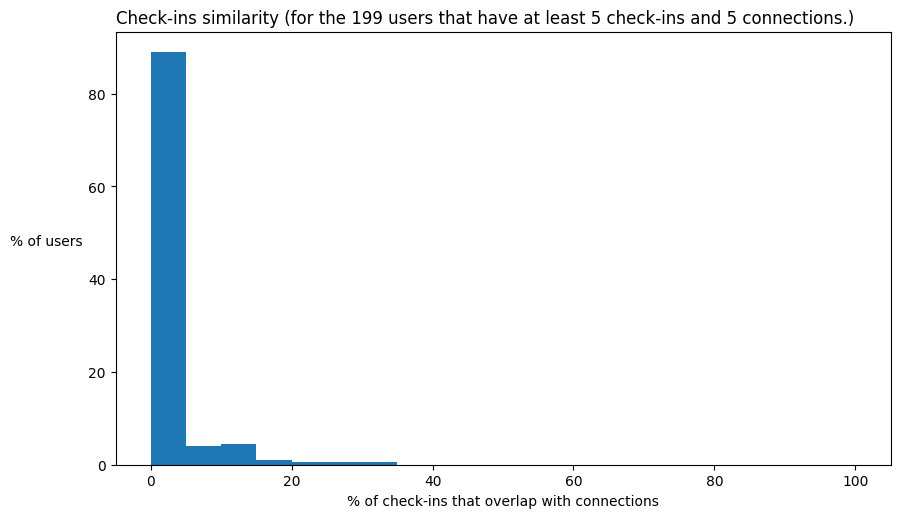

In [ ]:
sims = load_database('sims.pickle')

def make_sims_histogram(sims=sims):
    from numpy import histogram
    VISITS_THRESHOLD = 5
    CONNS_THRESHOLD = 5
    percent_in_common = [common/total*100 for num_conns, total, common in sims.values()
                         if total >= VISITS_THRESHOLD and num_conns >= CONNS_THRESHOLD]
    counts_in_common, bins_in_common = histogram(percent_in_common, bins=list(range(0, 105, 5)))
    print(list((c/len(percent_in_common)*100, b) for c, b in zip(counts_in_common, bins_in_common)))

    from matplotlib.pyplot import figure, hist, title, xlabel, ylabel
    figure(figsize=(10, 5.625))
    hist(bins_in_common[:-1], bins_in_common,
         weights=[c/len(percent_in_common)*100 for c in counts_in_common])
    title(f'Check-ins similarity (for the {len(percent_in_common):,} users that have at least {VISITS_THRESHOLD:,} check-ins and {CONNS_THRESHOLD:,} connections.)',
          loc='left')
    xlabel('% of check-ins that overlap with connections')
    ylabel('% of users', rotation=0, horizontalalignment='right')
    pass

make_sims_histogram()

# Part G: Recommending new connections #

The check-ins data allows us to do something interesting: we can try to suggest **new** connections based on similar visit behavior!

## Exercise 9 (**3** points): `suggest_friends` ##

Complete the function,
```python
def suggest_friends(user_id, visit_vectors, connection_vectors):
    ...
```
so that it **suggests new friends** for a given user. Here are the requirements:

**Inputs:**
- `user_id`: A user ID, given as an integer.
- `visit_vectors`: The collection of visit vectors for all users (see Part F, Exercise 7).
- `connection_vectors`: The collection of connection vectors for all users (see Part E, Exercise 6).

**Task:** Compare the visit vector for `user_id` against the visit vectors of all other users who have a visit vector but are **not** _already_ connected to that user. Return the top matches.

**Outputs:** Return the top 3 most similar candidates as a Python list of pairs. The first element of the pair is the suggested user ID and the second is the similarity measure. The output must be sorted in _descending_ order from most matches to fewest matches. Break ties using the user ID in _ascending_ order. If there are fewer than 3 matches, return them all.

**Notes:**
1. If user `user_id` does not have a visit vector, return an empty list.
2. The top "matches" (excluding existing connections) might have a similarity score of 0.

In [ ]:
### Define demo inputs
demo_user_id_ex9 = 101

demo_visit_vectors_ex9 = \
{100: {'e3832a', '344274'},
 101: {'9ae1fe', 'e3832a', 'e5495e', '344274'},
 102: {'e5495e'},
 103: {'e5495e', 'e3832a', '9ae1fe', '344274'},
 105: {'344274'},
 106: {'e5495e', 'e3832a', '9ae1fe'},
 107: {'e3832a'}}

demo_connection_vectors_ex9 = { \
  100: {101, 102, 103},
  101: {104, 100, 103},
  103: {101},
  104: {107, 100, 101, 103},
  105: {100},
  106: {107, 103}}

<!-- Expected demo output text block -->
A correct implementation should produce the following result on the demo inputs above:
```
[(106, 3), (102, 1), (105, 1)]
```
<!-- Include any shout outs here -->

In [ ]:
### Exercise 9 solution
def suggest_friends(user_id, visit_vectors, connection_vectors):
    '''
    GOAL:
    Compare the visit vector for user_id against the visit vectors of all other users who have a visit vector but are not already connected to that user.
    Return the top 3 most similar candidates as a Python list of pairs. The first element of the pair is the suggested user ID and the second is the similarity measure.
    The output must be sorted in descending order from most matches to fewest matches. Break ties using the user ID in ascending order.
    If there are fewer than 3 matches, return them all.
    If user_id does not have a visit vector, return an empty list.
    The top "matches" (excluding existing connections) might have a similarity score of 0.

    INPUT:
    user_id: A user ID, given as an integer
    visit_vectors: The collection of visit vectors for all users
    connection_vectors: The collection of connection vectors for all users

    STRATEGY:
    1. Create an empty list to hold the suggested friend pairs. Let's call this 'suggestion_list'
    2. Grab the dictionary of visits for our input user_id from 'visit_vectors'. Store dictionary in a variable called 'visits'
    3. If the user_id is in 'connection_vectors', store the dictionary value in a variable called 'already_friends'
    4. Iterate over potential_friends in 'visit_vectors'
    5. If 'potential_friend' is not already in 'already_friends' then it means we should compute its similarity score
    6. Compute similarity score between our user's visit vector 'visits' and the 'potential_friend' visit vector
    7. Append potential_friend user id and similarity score as a pair to our 'suggestion_list'
    8. After adding all potential friends, sort suggestion_list in descending order by second pair value (similarity score). Break ties using ascending order of potential friend's user id
    9. Return first three tuples in 'suggestion_list'
    '''

    # SOLUTION:
    suggestion_list = []

    visits = visit_vectors[user_id]
    if user_id in connection_vectors:
      already_friends = connection_vectors[user_id]
      for potential_friend in visit_vectors:
        if potential_friend not in already_friends:
          similarity_score = len(visits.intersection(visit_vectors[potential_friend]))
          suggestion_list.append((potential_friend, similarity_score))

      suggestion_list.sort(key=lambda s: (-s[1], s[0]))

    return suggestion_list[:3]


### demo function call
pprint(suggest_friends(demo_user_id_ex9, demo_visit_vectors_ex9, demo_connection_vectors_ex9))

[(101, 4), (106, 3), (102, 1)]


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 9. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution.
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output.

In [ ]:
### test_cell_ex9
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_9',
    'func': suggest_friends, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'user_id':{
            'dtype':'int', # data type of param.
            'check_modified':True,
        },
        'visit_vectors':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        },
        'connection_vectors':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'list',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'1ZePXzAcTR7lcNpmx1HRK0lT3v-Ikrg8mZ3n-wVFTBo=', path='')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

print('Passed! Please submit.')

AssertionError: ignored

# Fin: Submit your work! #

If you have made it this far, congratulations on completing the exam. **Don't forget to submit!**

If you are interested in exploring this topic after the exam is over, run the friend suggester on other users and see how the distribution of candidate matches compares to existing matches. Is there an improvement? Can you come up with a better method?